In [143]:
import requests
import time
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [183]:
with open('API_key.txt') as f:
    api_key = f.read()

In [ ]:
API_KEY = api_key
BASE_URL = 'http://quickstats.nass.usda.gov/api/api_GET/'
OUTPUT_DIR = 'corn_yield_csv'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Select years for collection
START_YEAR = 1910
END_YEAR = 2024

for year in range(START_YEAR, END_YEAR + 1):
    params = {
        'key': API_KEY,
        'commodity_desc': 'CORN',
        'statisticcat_desc': 'YIELD',
        'unit_desc': 'BU / ACRE',
        'agg_level_desc': 'COUNTY',
        'year': year,
        'format': 'JSON'
    }

    try:
        print(f"Downloading data for year {year}...")
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()

        records = data.get('data', [])
        if not records:
            print(f"No data for {year}, next.")
            continue

        df = pd.DataFrame(records)

        # Salva CSV per l'anno
        csv_path = os.path.join(OUTPUT_DIR, f"corn_yield_{year}_county.csv")
        df.to_csv(csv_path, index=False)
        print(f"Saved {csv_path} with {len(df)} record.")
        time.sleep(3)  

    except requests.exceptions.RequestException as e:
        print(f"Error for year {year}: {e}")
        time.sleep(5)

In [ ]:
INPUT_DIR = 'corn_yield_csv'
OUTPUT_FILE = 'corn_yield_all_years_county.csv'

files = [os.path.join(INPUT_DIR, f) for f in os.listdir(INPUT_DIR) if f.endswith('.csv')]
dfs = []

for file in sorted(files):
    print(f"Loading {file}...")
    df = pd.read_csv(file)

    # clean the 'Value' column
    def clean_value(val):
        try:
            return float(str(val).replace(",", ""))
        except:
            return None
    df['Value'] = df['Value'].apply(clean_value)

    dfs.append(df)

if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    full_df.to_csv(OUTPUT_FILE, index=False)
    print(f"Dataset complete saved in '{OUTPUT_FILE}'.")
else:
    print("There are no files to assemble")

Loading corn_yield_csv\corn_yield_1910_county.csv...
Loading corn_yield_csv\corn_yield_1911_county.csv...
Loading corn_yield_csv\corn_yield_1912_county.csv...
Loading corn_yield_csv\corn_yield_1913_county.csv...
Loading corn_yield_csv\corn_yield_1914_county.csv...
Loading corn_yield_csv\corn_yield_1915_county.csv...
Loading corn_yield_csv\corn_yield_1916_county.csv...
Loading corn_yield_csv\corn_yield_1917_county.csv...
Loading corn_yield_csv\corn_yield_1918_county.csv...
Loading corn_yield_csv\corn_yield_1919_county.csv...
Loading corn_yield_csv\corn_yield_1920_county.csv...
Loading corn_yield_csv\corn_yield_1921_county.csv...
Loading corn_yield_csv\corn_yield_1922_county.csv...
Loading corn_yield_csv\corn_yield_1923_county.csv...
Loading corn_yield_csv\corn_yield_1924_county.csv...
Loading corn_yield_csv\corn_yield_1925_county.csv...
Loading corn_yield_csv\corn_yield_1926_county.csv...
Loading corn_yield_csv\corn_yield_1927_county.csv...
Loading corn_yield_csv\corn_yield_1928_county.

In [145]:
df = pd.read_csv('corn_yield_all_years_county.csv')

In [146]:
df.describe()

,region_desc,state_fips_code,country_code,state_ansi,week_ending,county_code,county_ansi,congr_district_code,end_code,begin_code,Value,watershed_desc,watershed_code,CV (%),year,zip_5,asd_code
count,0.00,"221,557.00","221,557.00","221,557.00",0.00,"221,557.00","213,879.00",0.00,"221,557.00","221,557.00","221,557.00",0.00,"221,557.00","7,506.00","221,557.00",0.00,"221,557.00"
mean,NaN,30.09,"9,000.00",30.09,NaN,124.45,93.09,NaN,0.00,0.00,81.04,NaN,0.00,5.56,"1,978.09",NaN,49.89
std,NaN,13.26,0.00,13.26,NaN,179.48,70.65,NaN,0.00,0.00,48.96,NaN,0.00,4.51,25.60,NaN,25.50
min,NaN,1.00,"9,000.00",1.00,NaN,1.00,1.00,NaN,0.00,0.00,0.00,NaN,0.00,0.50,"1,910.00",NaN,10.00
25%,NaN,20.00,"9,000.00",20.00,NaN,41.00,39.00,NaN,0.00,0.00,40.00,NaN,0.00,2.70,"1,960.00",NaN,30.00
50%,NaN,29.00,"9,000.00",29.00,NaN,87.00,83.00,NaN,0.00,0.00,73.60,NaN,0.00,4.10,"1,980.00",NaN,50.00
75%,NaN,39.00,"9,000.00",39.00,NaN,139.00,133.00,NaN,0.00,0.00,114.60,NaN,0.00,6.90,"1,998.00",NaN,70.00
max,NaN,56.00,"9,000.00",56.00,NaN,998.00,810.00,NaN,0.00,0.00,296.30,NaN,0.00,63.40,"2,024.00",NaN,99.00


In [147]:
df.columns

Index(['source_desc', 'region_desc', 'group_desc', 'agg_level_desc',
       'state_name', 'country_name', 'statisticcat_desc', 'domaincat_desc',
       'state_fips_code', 'country_code', 'sector_desc', 'state_ansi',
       'week_ending', 'county_code', 'prodn_practice_desc', 'county_ansi',
       'reference_period_desc', 'congr_district_code', 'unit_desc', 'end_code',
       'asd_desc', 'load_time', 'begin_code', 'Value', 'domain_desc',
       'util_practice_desc', 'watershed_desc', 'short_desc', 'watershed_code',
       'class_desc', 'commodity_desc', 'freq_desc', 'county_name', 'CV (%)',
       'state_alpha', 'location_desc', 'year', 'zip_5', 'asd_code'],
      dtype='object')

In [148]:
interest_columns = ['year','country_name','state_name','county_name','Value']

In [149]:
df = df.loc[:, interest_columns]

In [150]:
df.isna().sum()

year            0
country_name    0
state_name      0
county_name     0
Value           0
dtype: int64

In [151]:
# Groupby for state and year
state_df = full_df.groupby(['year', 'state_name'])['Value'].mean().reset_index()

# For national average
national_df = full_df.groupby(['year'])['Value'].mean().reset_index()

In [152]:
df.head()

,year,country_name,state_name,county_name,Value
0,1910,UNITED STATES,NEBRASKA,BANNER,14.40
1,1910,UNITED STATES,NEBRASKA,BOX BUTTE,16.00
2,1910,UNITED STATES,NEBRASKA,CHEYENNE,9.60
3,1910,UNITED STATES,NEBRASKA,DAWES,16.40
4,1910,UNITED STATES,NEBRASKA,DEUEL,17.50


In [153]:
df['Value'].describe()

count   221,557.00
mean         81.04
std          48.96
min           0.00
25%          40.00
50%          73.60
75%         114.60
max         296.30
Name: Value, dtype: float64

c:\ProgramData\anaconda3\envs\env_master\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


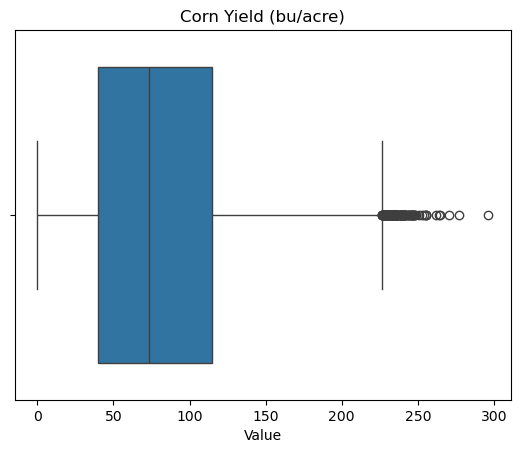

In [154]:
sns.boxplot(df['Value'], orient='h')
plt.title('Corn Yield (bu/acre)')
plt.show()

In [155]:
hist_wx_df = pd.read_parquet('take_home_exam/hist_wx_df.parquet')

In [156]:
hist_wx_df.head()

,aoi_id,date,tmax,tmin,precip,swvl1,swvl2,adm2_name,adm1_name
0,USA.14.100_1,2000-01-01,9.15,-0.30,0.00,0.33,0.32,Will,Illinois
1,USA.14.100_1,2000-01-02,16.08,4.77,0.00,0.34,0.32,Will,Illinois
2,USA.14.100_1,2000-01-03,9.56,1.65,0.47,0.34,0.32,Will,Illinois
3,USA.14.100_1,2000-01-04,3.09,-3.19,1.18,0.38,0.34,Will,Illinois
4,USA.14.100_1,2000-01-05,-1.60,-8.90,0.00,0.35,0.34,Will,Illinois


In [157]:
hist_wx_df.corr(numeric_only=True)

,tmax,tmin,precip,swvl1,swvl2
tmax,1.00,0.95,0.11,-0.34,-0.31
tmin,0.95,1.00,0.18,-0.28,-0.26
precip,0.11,0.18,1.00,0.18,0.11
swvl1,-0.34,-0.28,0.18,1.00,0.95
swvl2,-0.31,-0.26,0.11,0.95,1.00


In [158]:
hist_wx_df.describe().round(2)

,date,tmax,tmin,precip,swvl1,swvl2
count,8527402,"8,527,402.00","8,527,402.00","8,527,402.00","8,527,402.00","8,527,402.00"
mean,2012-03-02 03:27:13.931177984,16.46,6.88,2.36,0.32,0.32
min,2000-01-01 00:00:00,-32.29,-41.80,0.00,0.05,0.06
25%,2006-02-01 00:00:00,7.55,-1.34,0.00,0.27,0.26
50%,2012-03-03 00:00:00,17.97,7.70,0.00,0.34,0.33
75%,2018-04-02 00:00:00,26.25,16.38,1.50,0.38,0.38
max,2024-04-30 00:00:00,44.19,31.56,224.63,0.63,0.63
std,NaN,11.63,11.14,6.34,0.08,0.08


In [159]:
hist_wx_df.isnull().sum()

aoi_id       0
date         0
tmax         0
tmin         0
precip       0
swvl1        0
swvl2        0
adm2_name    0
adm1_name    0
dtype: int64

c:\ProgramData\anaconda3\envs\env_master\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='tmax'>

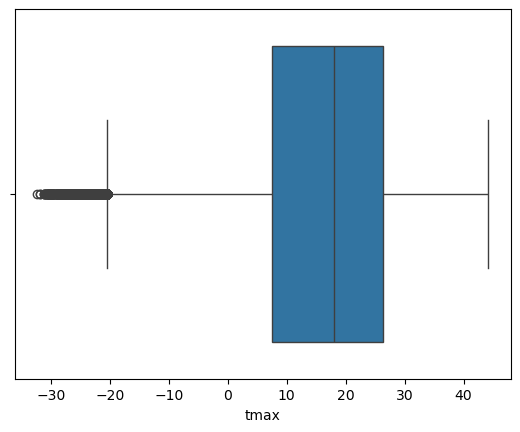

In [160]:
sns.boxplot(hist_wx_df['tmax'], orient='h')

c:\ProgramData\anaconda3\envs\env_master\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='tmin'>

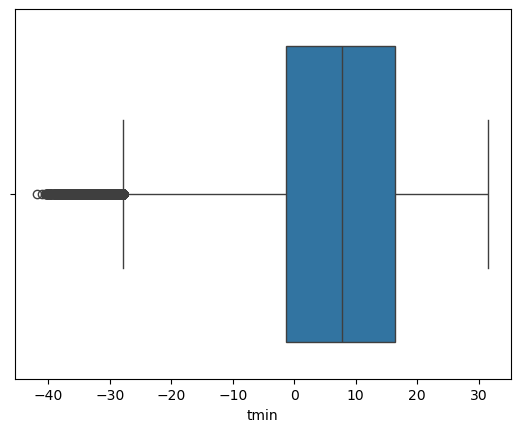

In [161]:
sns.boxplot(hist_wx_df['tmin'], orient='h')

The box plot you show clearly highlights a common problem in precipitation data:
the presence of very high outliers and a strongly asymmetrical (skewed) distribution because probabily there a lot of days without rain.

c:\ProgramData\anaconda3\envs\env_master\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='precip'>

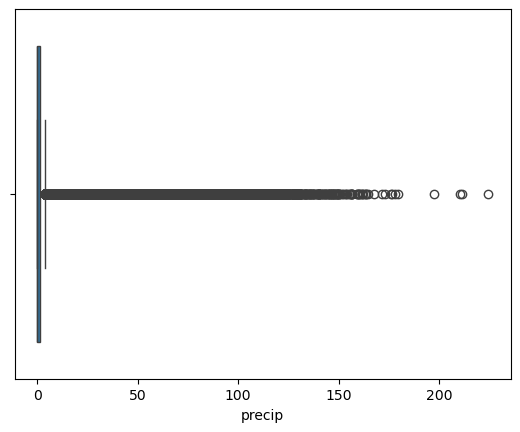

In [162]:
sns.boxplot(hist_wx_df['precip'], orient='h')

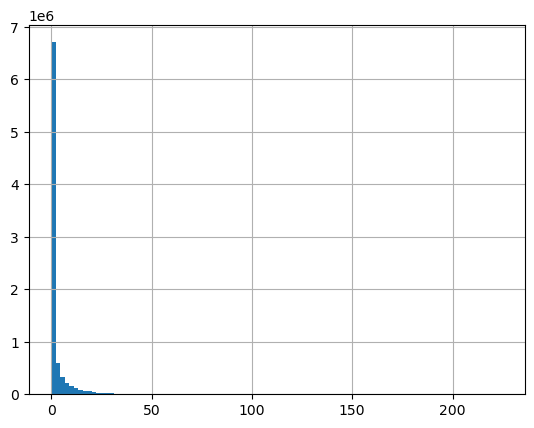

In [163]:
hist_wx_df['precip'].hist(bins=100)
plt.show()

In [164]:
hist_wx_df['rain_flag'] = pd.cut(
    hist_wx_df['precip'],
    bins=[-0.1, 0, 50, float('inf')],
    labels=[0, 1, 2],
    right=True
).astype(int)

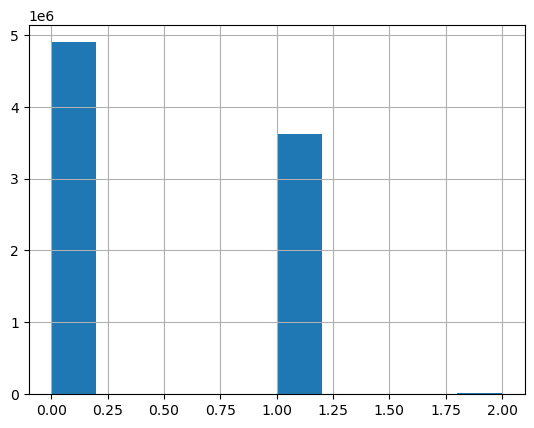

In [165]:
hist_wx_df['rain_flag'].hist()
plt.show()

In [166]:
ts = df.set_index('year')

In [167]:
ts_yield = pd.Series(ts['Value'])

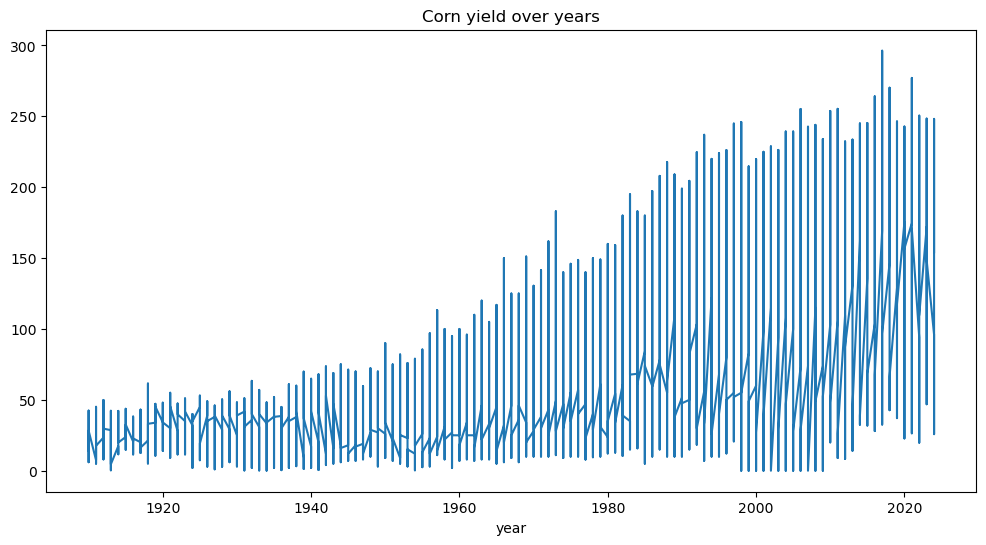

In [174]:
ts_yield.plot(legend=False, title='Corn yield over years', figsize=(12, 6))
plt.show()

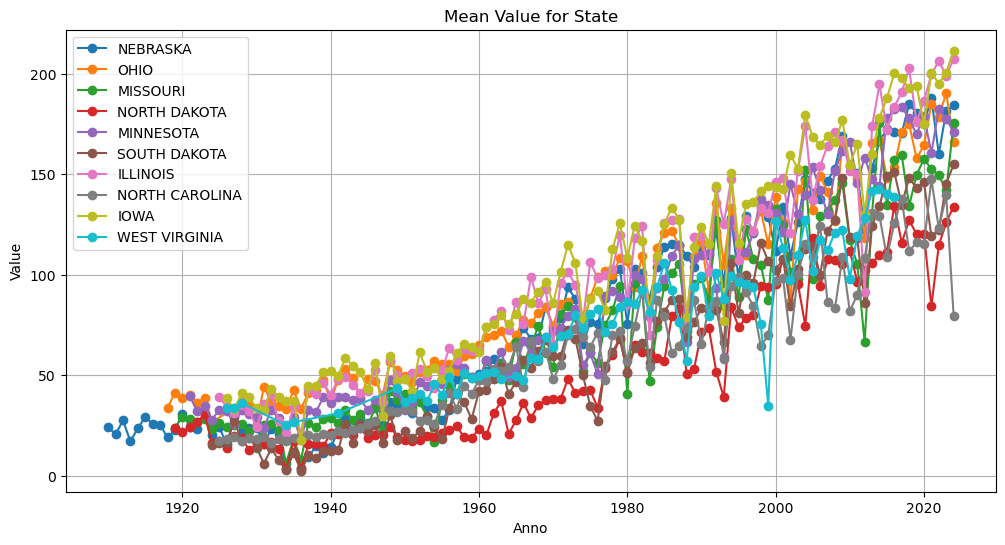

In [180]:
# Series for state
state_time_series = df.groupby(['year', 'state_name'])['Value'].mean().reset_index()

# Graph for the firts 10 states
states_to_plot = state_time_series['state_name'].unique()[:10]  

plt.figure(figsize=(12, 6))
for state in states_to_plot:
    data = state_time_series[state_time_series['state_name'] == state]
    plt.plot(data['year'], data['Value'], marker='o', label=state)

plt.title("Mean Value for State")
plt.xlabel("Anno")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

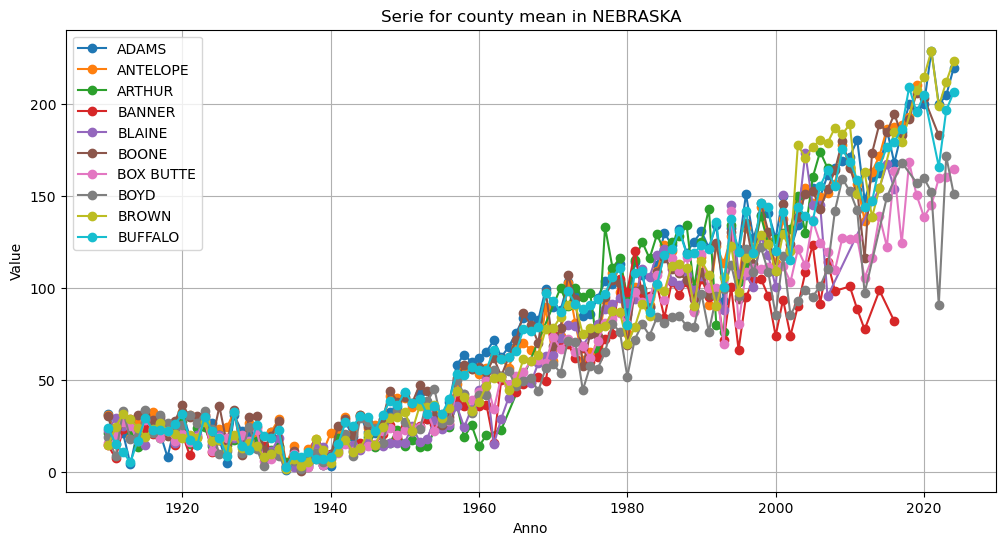

In [179]:
# Serie for county in a specific state
state_example = 'NEBRASKA'
county_time_series = df[df['state_name'] == state_example].groupby(['year', 'county_name'])['Value'].mean().reset_index()

# Selezioniamo alcuni county per il grafico (massimo 5)
counties_to_plot = county_time_series['county_name'].unique()[:10]

plt.figure(figsize=(12, 6))
for county in counties_to_plot:
    data = county_time_series[county_time_series['county_name'] == county]
    plt.plot(data['year'], data['Value'], marker='o', label=county)

plt.title(f"Serie for county mean in {state_example}")
plt.xlabel("Anno")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()